In [1]:
from ferry_portfolio_pipeline.config.settings import CONFIG
import boto3
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

bucket = CONFIG["s3"]["bucket"]
input_key = CONFIG["s3"]["key"]
output_key = CONFIG["s3"]["output_key"]

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=input_key)
data = obj['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(data))


In [2]:
df

,_id,Timestamp,Redemption Count,Sales Count
0,1,2025-08-06T19:45:00,55,72
1,2,2025-08-06T19:30:00,105,93
2,3,2025-08-06T19:15:00,61,80
3,4,2025-08-06T19:00:00,95,147
4,5,2025-08-06T18:45:00,70,77
...,...,...,...,...
251583,251584,2015-05-04T16:00:00,0,2
251584,251585,2015-05-01T16:00:00,1,0
251585,251586,2015-05-01T15:45:00,0,1
251586,251587,2015-05-01T15:15:00,0,2


In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [4]:
df['Date'] = df['Timestamp'].dt.date
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Timestamp'].dt.day_name()
df['Weekday'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['Hour'] = df['Timestamp'].dt.hour

In [5]:
df.drop(columns=['Timestamp','_id'], inplace=True)

In [6]:
df = df.sort_values('Date').set_index("Date")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251588 entries, 2015-05-01 to 2025-08-06
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Redemption Count  251588 non-null  int64 
 1   Sales Count       251588 non-null  int64 
 2   Day               251588 non-null  object
 3   Weekday           251588 non-null  int32 
 4   Month             251588 non-null  int32 
 5   Year              251588 non-null  int32 
 6   Hour              251588 non-null  int32 
dtypes: int32(4), int64(2), object(1)
memory usage: 11.5+ MB


In [8]:
print(df.isnull().sum())

Redemption Count    0
Sales Count         0
Day                 0
Weekday             0
Month               0
Year                0
Hour                0
dtype: int64


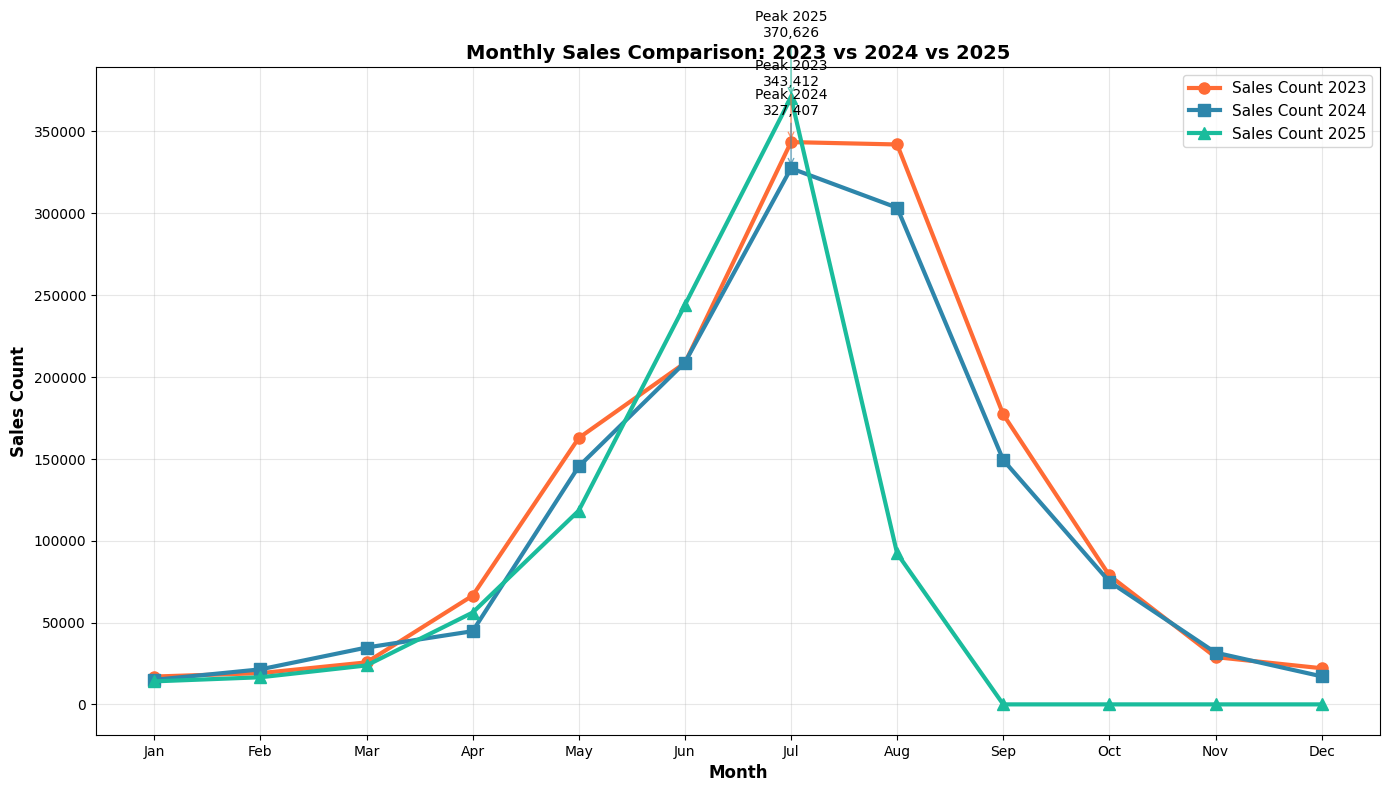

Year-over-Year Growth by Month (%):
Jan: -11.9%
Feb: 12.1%
Mar: 35.2%
Apr: -32.7%
May: -10.7%
Jun: 0.1%
Jul: -4.7%
Aug: -11.3%
Sep: -15.7%
Oct: -4.8%
Nov: 9.5%
Dec: -22.4%


In [9]:
# Create a complete month range (1-12) and reindex to handle missing months
month_range = range(1, 13)

# Group data by Year and Month, then sum the Sales Count
monthly_2023 = df[df['Year'] == 2023].groupby('Month')['Sales Count'].sum().reindex(month_range, fill_value=0)
monthly_2024 = df[df['Year'] == 2024].groupby('Month')['Sales Count'].sum().reindex(month_range, fill_value=0)
monthly_2025 = df[df['Year'] == 2025].groupby('Month')['Sales Count'].sum().reindex(month_range, fill_value=0)

# Create the plot with enhanced styling
plt.figure(figsize=(14, 8))

# Plot with different colors and styles
plt.plot(monthly_2023.index, monthly_2023.values, 
         label='Sales Count 2023', marker='o', linewidth=3, 
         color='#FF6B35', markersize=8)
plt.plot(monthly_2024.index, monthly_2024.values, 
         label='Sales Count 2024', marker='s', linewidth=3, 
         color='#2E86AB', markersize=8)
plt.plot(monthly_2025.index, monthly_2025.values, 
         label='Sales Count 2025', marker='^', linewidth=3, 
         color='#1ABC9C', markersize=8)
# Customize the plot
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Sales Count', fontsize=12, fontweight='bold')
plt.title('Monthly Sales Comparison: 2023 vs 2024 vs 2025', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Set x-axis to show all months
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)

# Add value annotations on peaks (optional)
max_2023_month = monthly_2023.idxmax()
max_2024_month = monthly_2024.idxmax()
plt.annotate(f'Peak 2023\n{monthly_2023.max():,}', 
             xy=(max_2023_month, monthly_2023.max()), 
             xytext=(max_2023_month, monthly_2023.max() + monthly_2023.max()*0.1),
             ha='center', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='#FF6B35', alpha=0.7))
plt.annotate(f'Peak 2024\n{monthly_2024.max():,}', 
             xy=(max_2024_month, monthly_2024.max()), 
             xytext=(max_2024_month, monthly_2024.max() + monthly_2024.max()*0.1),
             ha='center', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='#2E86AB', alpha=0.7))
plt.annotate(f'Peak 2025\n{monthly_2025.max():,}', 
             xy=(monthly_2025.idxmax(), monthly_2025.max()), 
             xytext=(monthly_2025.idxmax(), monthly_2025.max() + monthly_2025.max()*0.1),
             ha='center', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='#1ABC9C', alpha=0.7))

plt.tight_layout()
plt.show()

# Calculate and display year-over-year growth
yoy_growth = ((monthly_2024 - monthly_2023) / monthly_2023 * 100).replace([float('inf'), -float('inf')], 0)
print("Year-over-Year Growth by Month (%):")
for month, growth in zip(month_names, yoy_growth):
    print(f"{month}: {growth:.1f}%")

<Axes: xlabel='Day'>

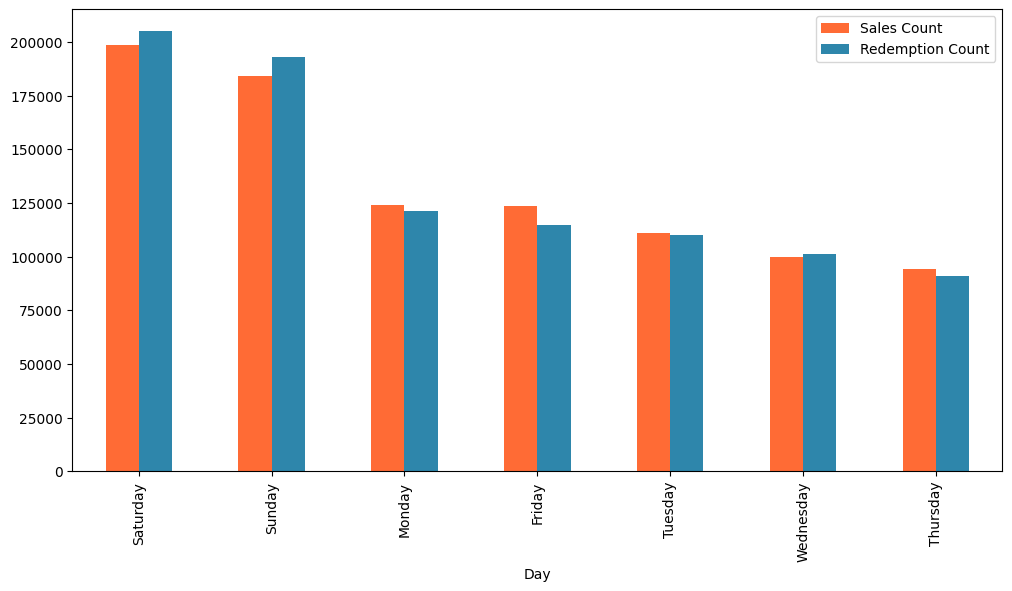

In [10]:
df_2025 = df[df['Year'] == 2025]
df_2025.groupby(['Day']).sum()[['Sales Count','Redemption Count']].sort_values('Redemption Count', ascending=False).plot(kind='bar', figsize=(12, 6), color=['#FF6B35', '#2E86AB'])

<Axes: xlabel='Day'>

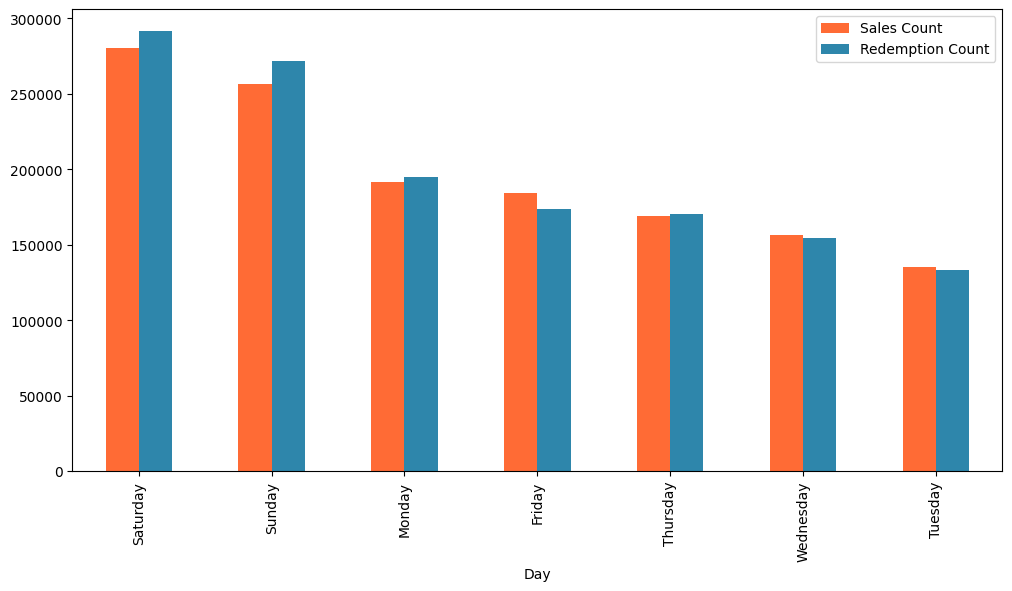

In [11]:
df_2024 = df[df['Year'] == 2024]
df_2024.groupby(['Day']).sum()[['Sales Count','Redemption Count']].sort_values('Redemption Count', ascending=False).plot(kind='bar', figsize=(12, 6), color=['#FF6B35', '#2E86AB'])

<Figure size 640x480 with 0 Axes>

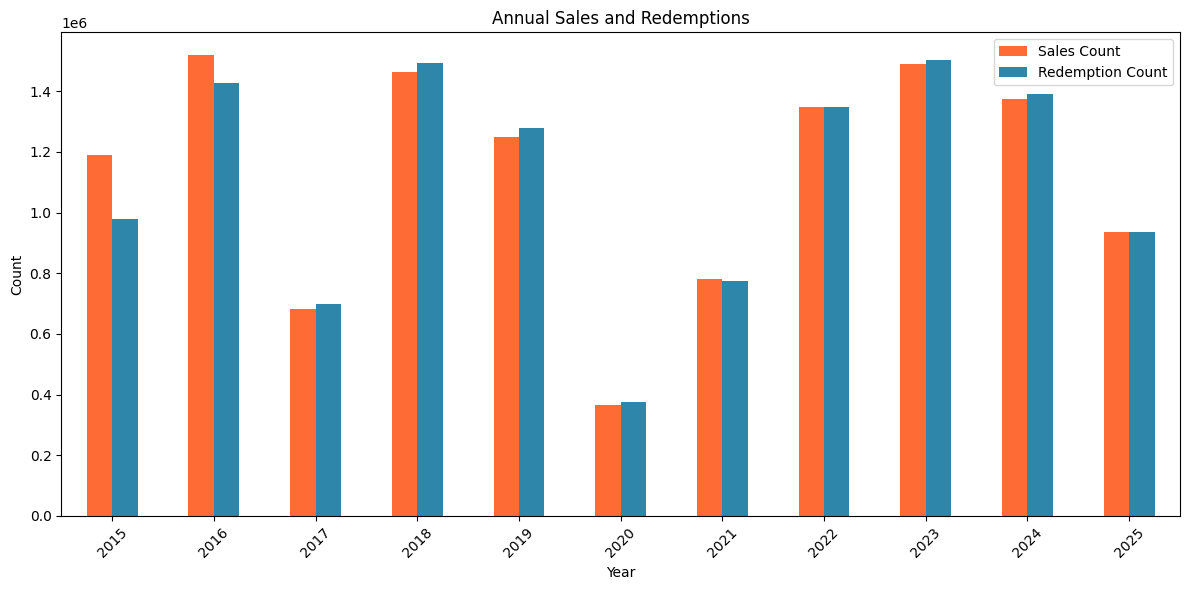

In [12]:
plt.close('all')
plt.clf()


df.groupby(['Year']).sum()[['Sales Count','Redemption Count']].sort_values('Year').plot(kind='bar', figsize=(12, 6), color=['#FF6B35', '#2E86AB'])

plt.yscale('linear')  # 👈 this disables log scale
plt.ylabel('Count')
plt.title('Annual Sales and Redemptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
new_df = df[df['Year'].isin([2022,2023, 2024, 2025])]


In [14]:
monthly_new = new_df.groupby(['Year','Month']).sum()[['Sales Count','Redemption Count']].sort_values('Month')

In [15]:
monthly_new.head()

,,Sales Count,Redemption Count
Year,Month,,
2022,1,13708,15559
2024,1,14978,18141
2025,1,14059,17129
2023,1,17005,20105
2022,2,12440,14698


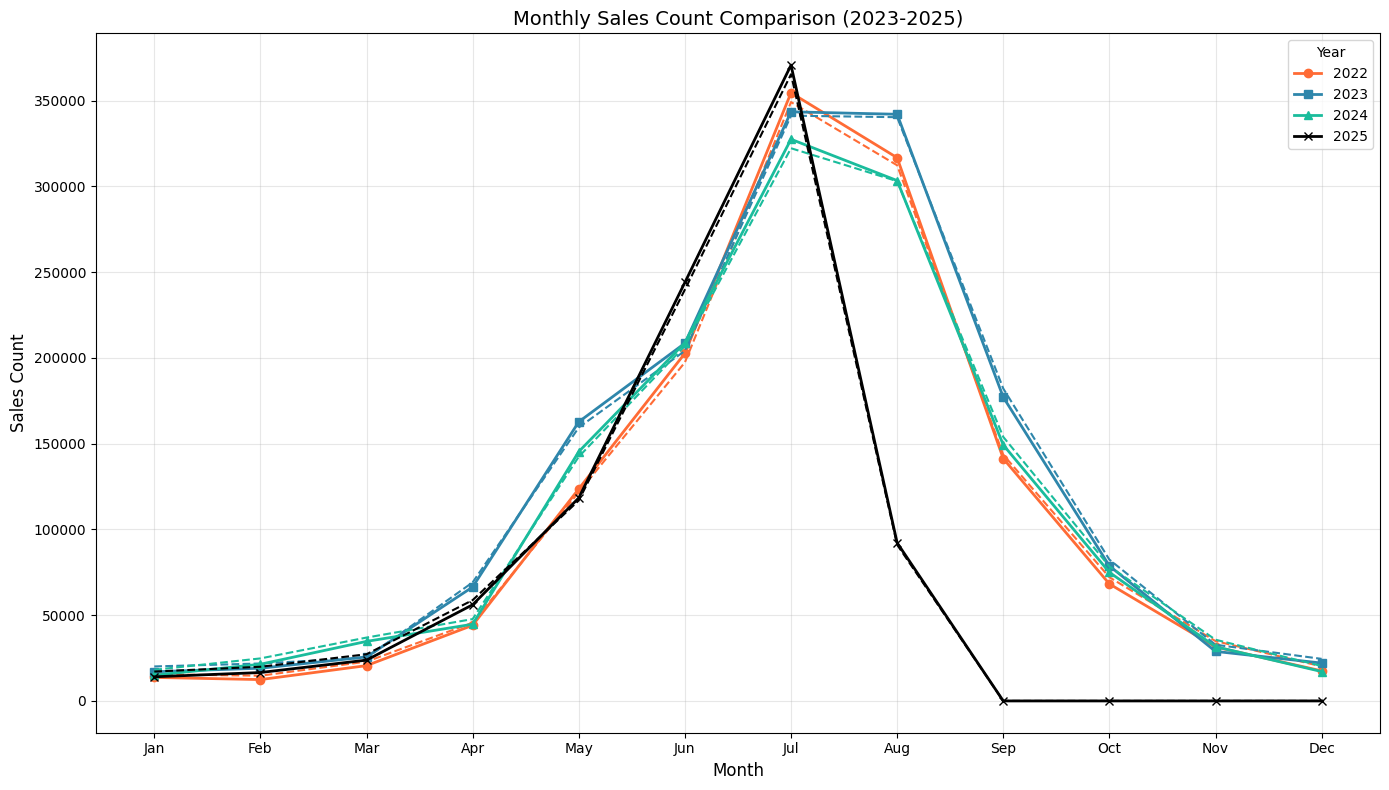

In [16]:
plt.figure(figsize=(14, 8))

for year, color, marker in zip([2022,2023, 2024, 2025], ['#FF6B35', '#2E86AB', '#1ABC9C','Black'], ['o', 's', '^', 'x']):
    sales = monthly_new.loc[year]['Sales Count'].reindex(range(1, 13), fill_value=0)
    redemptions = monthly_new.loc[year]['Redemption Count'].reindex(range(1, 13), fill_value=0)
    plt.plot(sales.index, sales.values, label=str(year), marker=marker, linewidth=2, color=color)
    plt.plot(redemptions.index, redemptions.values, linestyle='--', color=color, linewidth=1.5)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.title('Monthly Sales Count Comparison (2023-2025)', fontsize=14)
plt.xticks(range(1, 13), month_names)
plt.legend(title='Year')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


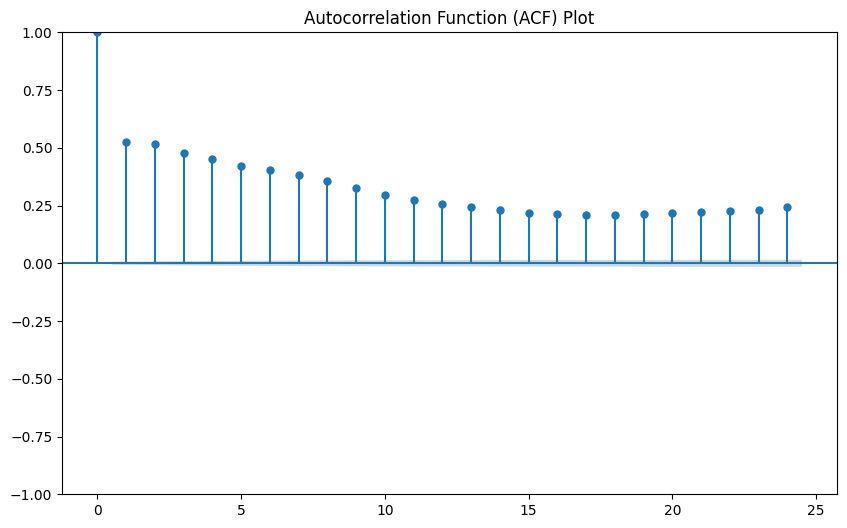

In [17]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Create the ACF plot
# The `lags` parameter specifies how many lags to display on the x-axis.
# For monthly data with yearly seasonality, `lags=24` (2 years) is a good starting point.
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(new_df['Sales Count'], lags=24, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
plt.show()

In [18]:
df

,Redemption Count,Sales Count,Day,Weekday,Month,Year,Hour
Date,,,,,,,
2015-05-01,0,1,Friday,1,5,2015,13
2015-05-01,1,0,Friday,1,5,2015,16
2015-05-01,0,2,Friday,1,5,2015,15
2015-05-01,0,1,Friday,1,5,2015,15
2015-05-04,0,2,Monday,4,5,2015,16
...,...,...,...,...,...,...,...
2025-08-06,7,24,Wednesday,6,8,2025,7
2025-08-06,11,18,Wednesday,6,8,2025,7
2025-08-06,12,43,Wednesday,6,8,2025,7


In [19]:
df_date = df.groupby(['Date']).sum()[['Sales Count','Redemption Count']]

In [20]:
df_monthly = df.resample('M').sum()[['Sales Count']]

C:\Users\91812\AppData\Local\Temp\ipykernel_13740\2467196995.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()[['Sales Count']]


In [21]:
df_monthly

,Sales Count
Date,
2015-05-31,97285
2015-06-30,163212
2015-07-31,328440
2015-08-31,371106
2015-09-30,159839
...,...
2025-04-30,56079
2025-05-31,118338
2025-06-30,243934


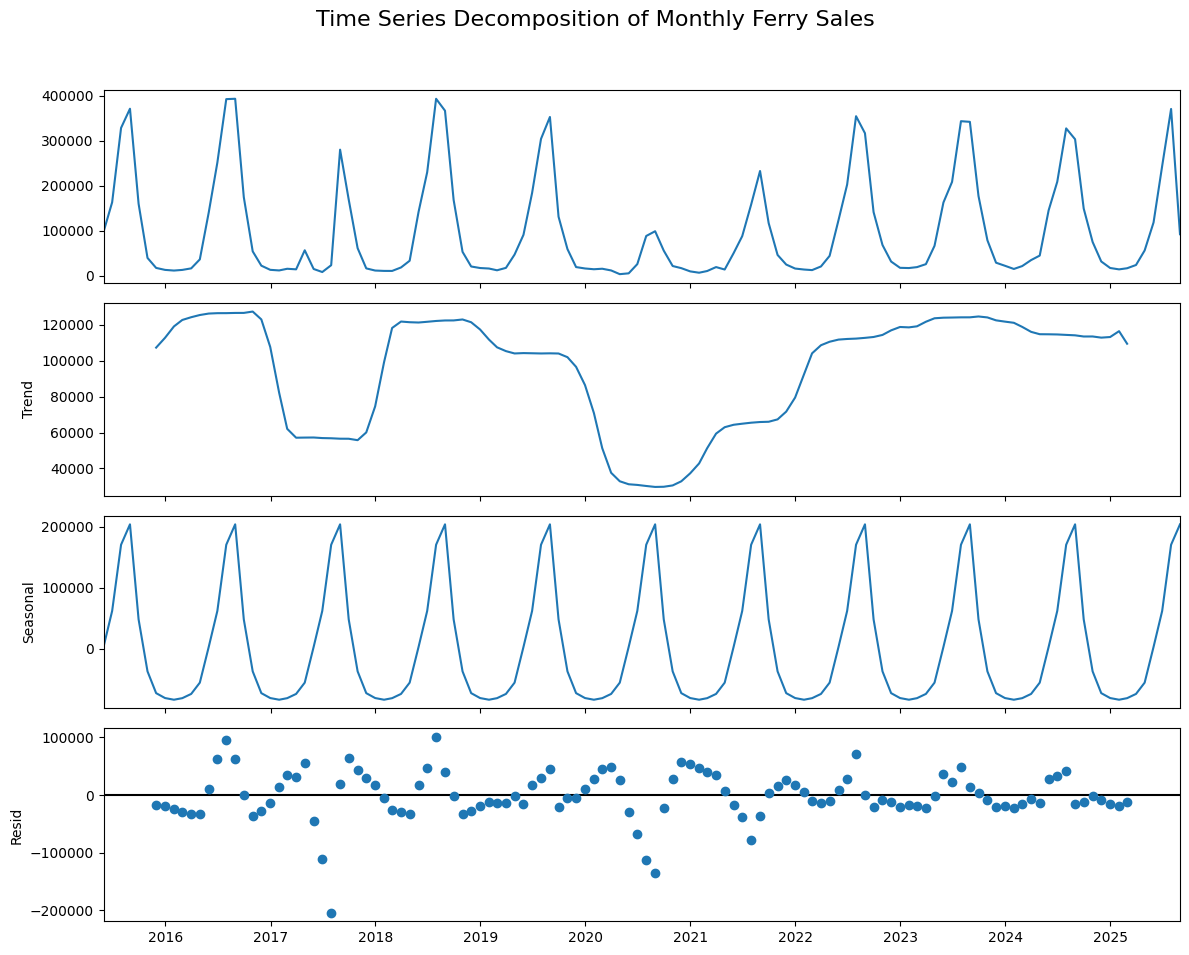

In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Step 2: Perform the Decomposition ---
# The period for your monthly data with a yearly pattern is 12.
# We'll use the 'multiplicative' model because your sales chart suggests
# the seasonal peaks are growing along with the overall trend.
decomposition = sm.tsa.seasonal_decompose(df_monthly, model='additive', period=12)

# --- Step 3: Plot the Components ---
fig = decomposition.plot()
fig.set_size_inches(12, 10)
fig.suptitle('Time Series Decomposition of Monthly Ferry Sales', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# You can also access the components directly if you need them for further analysis
# trend_component = decomposition.trend
# seasonal_component = decomposition.seasonal
# residual_component = decomposition.resid

In [23]:
df_2021 = df[df['Year'] >= 2021]
df_2021 = df_2021.resample('M').sum()[['Sales Count']]

C:\Users\91812\AppData\Local\Temp\ipykernel_13740\2623528883.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_2021 = df_2021.resample('M').sum()[['Sales Count']]


In [24]:
df_2021.reset_index(inplace=True)
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021.rename(columns={'Date': 'ds' , 'Sales Count' : 'y'}, inplace=True)


In [25]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      56 non-null     datetime64[ns]
 1   y       56 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 KB


In [26]:
cut_off_date = '2024-01-01'
last_date = '2025-08-01'

# df_2021 = df_2021[df_2021['ds'] < last_date]  # Example cut-off date, adjust as needed

train_df = df_2021[df_2021['ds'] < cut_off_date].copy()
test_df = df_2021[df_2021['ds'] >= cut_off_date].copy()



In [42]:
train_df

,ds,y
0,2021-01-31,6621
1,2021-02-28,10383
2,2021-03-31,19167
3,2021-04-30,13745
4,2021-05-31,50073
5,2021-06-30,87936
6,2021-07-31,158094
7,2021-08-31,232700
8,2021-09-30,116844
9,2021-10-31,46132


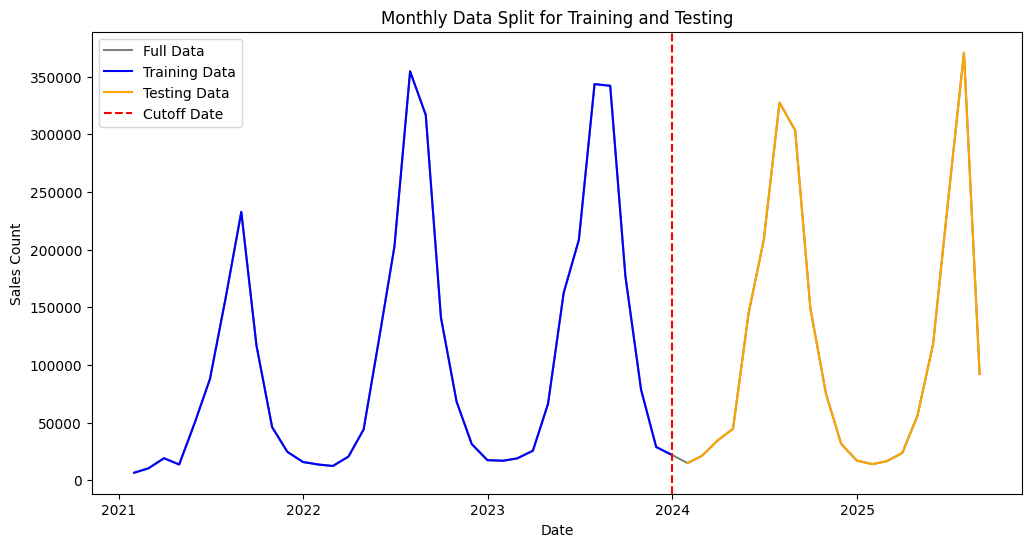

In [27]:
 #Visualize the split to confirm it's correct
plt.figure(figsize=(12, 6))
plt.plot(df_2021['ds'], df_2021['y'], label='Full Data', color='gray')
plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Testing Data', color='orange')
plt.axvline(pd.to_datetime(cut_off_date), color='red', linestyle='--', label='Cutoff Date')
plt.title('Monthly Data Split for Training and Testing')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.legend()
plt.show()

In [28]:
from prophet import Prophet

# Initialize the Prophet model
m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')

# Fit the model to the training data
m.fit(train_df)

# Create a DataFrame with future dates to be forecasted.
# The number of periods should match the length of your test_df.
future = m.make_future_dataframe(periods=len(test_df), freq='M')

# Make the forecast
forecast = m.predict(future)

# Select the relevant forecast columns and merge with test_df
forecast_test = forecast[['ds', 'yhat']].tail(len(test_df))
evaluation_df = test_df.merge(forecast_test, on='ds')

g:\DATASCIENCE\End_to_End_Project\DataAnalysis\Ferry_Forecasting\ferry\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
13:04:06 - cmdstanpy - INFO - Chain [1] start processing
13:04:07 - cmdstanpy - INFO - Chain [1] done processing
g:\DATASCIENCE\End_to_End_Project\DataAnalysis\Ferry_Forecasting\ferry\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat']))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['yhat']) / evaluation_df['y'])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Root Mean Squared Error (RMSE): 86636.82332754486
Mean Absolute Percentage Error (MAPE): 50.19%


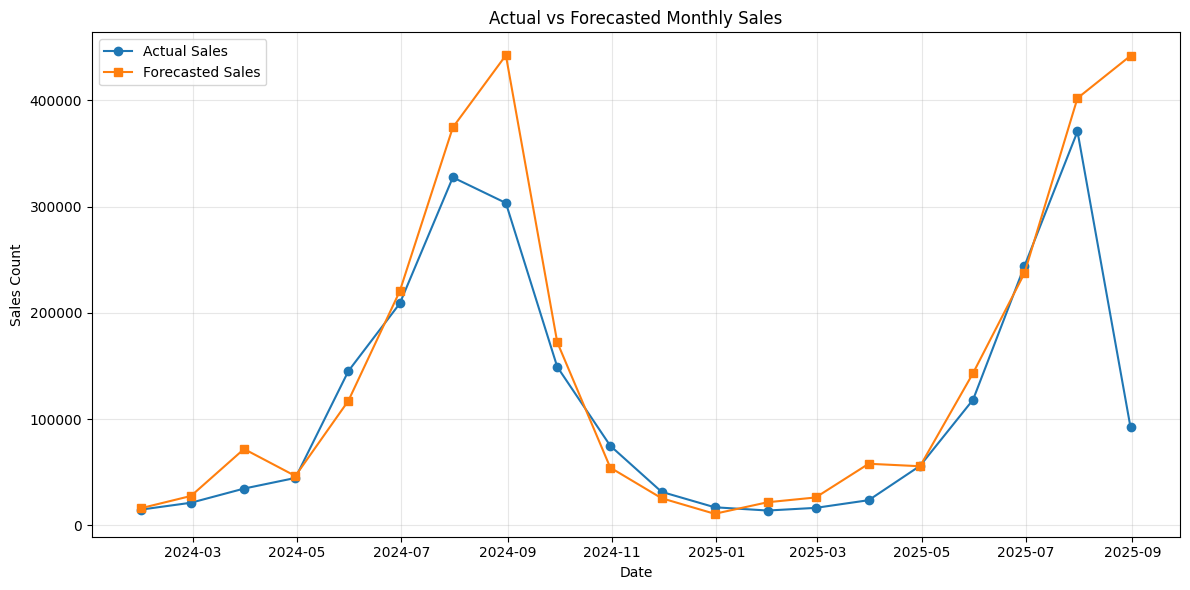

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(evaluation_df['ds'], evaluation_df['y'], label='Actual Sales', marker='o')
plt.plot(evaluation_df['ds'], evaluation_df['yhat'], label='Forecasted Sales', marker='s')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('Actual vs Forecasted Monthly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet

# Perform cross-validation
# Let's use a 3-year initial training period, with a 6-month period between cutoffs,
# and evaluate forecasts 12 months out.
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='180 days')

print("Cross-Validation Results (Head):")
print(df_cv.head())


  0%|          | 0/1 [00:00<?, ?it/s]13:04:08 - cmdstanpy - INFO - Chain [1] start processing
13:04:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

Cross-Validation Results (Head):
          ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2023-07-31  499108.132865  492614.339513  505581.104537  343412 2023-07-04
1 2023-08-31  313189.122075  306616.489740  320072.086533  341973 2023-07-04
2 2023-09-30  152502.728930  145751.007936  159753.367955  177064 2023-07-04
3 2023-10-31  110042.189467  103199.063849  116775.483149   78723 2023-07-04
4 2023-11-30   56922.519347   50808.910580   63583.120320   28877 2023-07-04


In [32]:
from prophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt

# Assume `df_cv` is the DataFrame you got from the previous step.

# Calculate the performance metrics, averaging over all cross-validation folds.
# We'll use a rolling window to smooth the results for better visualization.
df_p = performance_metrics(df_cv, rolling_window=0.1)

print("\nPerformance Metrics (Head):")
print(df_p.head())
print("\nPerformance Metrics (Tail):")
print(df_p.tail())


Performance Metrics (Head):
   horizon           mse           rmse            mae      mape     mdape  \
0  27 days  2.424129e+10  155696.132865  155696.132865  0.453380  0.453380   
1  58 days  8.285116e+08   28783.877925   28783.877925  0.084170  0.084170   
2  88 days  6.032560e+08   24561.271070   24561.271070  0.138714  0.138714   
3 119 days  9.808916e+08   31319.189467   31319.189467  0.397840  0.397840   
4 149 days  7.865512e+08   28045.519347   28045.519347  0.971206  0.971206   

      smape  coverage  
0  0.369596       0.0  
1  0.087868       0.0  
2  0.149052       0.0  
3  0.331832       0.0  
4  0.653745       0.0  

Performance Metrics (Tail):
   horizon           mse          rmse           mae      mape     mdape  \
1  58 days  8.285116e+08  28783.877925  28783.877925  0.084170  0.084170   
2  88 days  6.032560e+08  24561.271070  24561.271070  0.138714  0.138714   
3 119 days  9.808916e+08  31319.189467  31319.189467  0.397840  0.397840   
4 149 days  7.865512e+08 

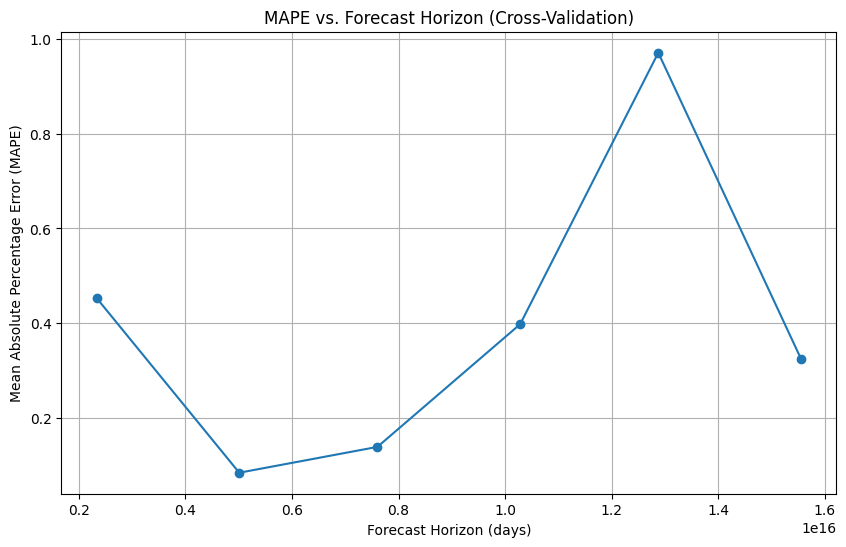

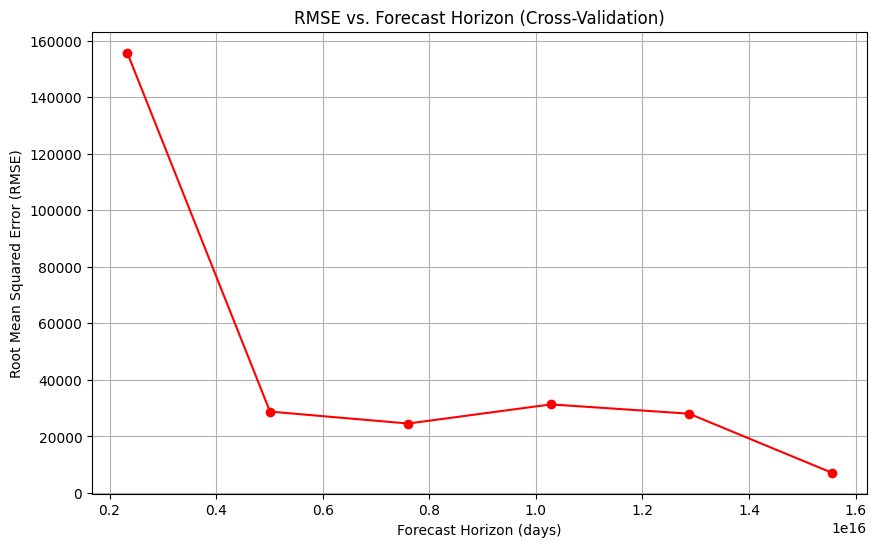

In [33]:
# Plot the Mean Absolute Percentage Error (MAPE) vs. Horizon
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['mape'], marker='o')
plt.title('MAPE vs. Forecast Horizon (Cross-Validation)')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.grid(True)
plt.show()

# Plot the Root Mean Squared Error (RMSE) vs. Horizon
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['rmse'], marker='o', color='red')
plt.title('RMSE vs. Forecast Horizon (Cross-Validation)')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

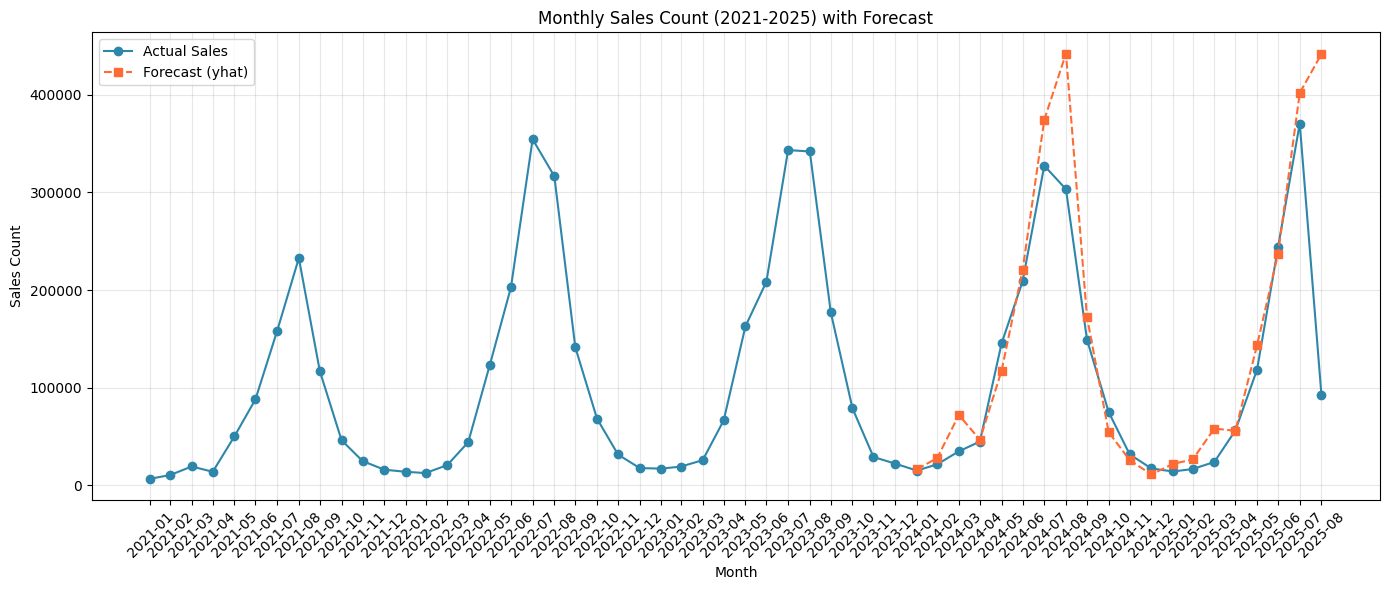

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(df_2021['ds'], df_2021['y'], marker='o', linestyle='-', color='#2E86AB', label='Actual Sales')
plt.plot(evaluation_df['ds'], evaluation_df['yhat'], marker='s', linestyle='--', color='#FF6B35', label='Forecast (yhat)')
plt.title('Monthly Sales Count (2021-2025) with Forecast')
plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.xticks(df_2021['ds'], df_2021['ds'].dt.strftime('%Y-%m'), rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd

# List of parameters to test
changepoint_values = [0.01, 0.05, 0.1, 0.5] # Test a range of trend flexibility
seasonality_values = [1.0, 5.0, 10.0, 20.0]  # Your best guess from before

results = []

for c_val in changepoint_values:
    for s_val in seasonality_values:
        print(f"Running cross-validation with changepoint_prior_scale={c_val}, seasonality_prior_scale={s_val}...")

        # Initialize and fit the model with the new parameters
        m = Prophet(
            yearly_seasonality=True,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=c_val,
            seasonality_prior_scale=s_val
        )
        m.fit(df_2021)

        # Perform cross-validation and get the average MAPE
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='180 days')
        df_p = performance_metrics(df_cv)
        mape = np.mean(df_p['mape'])
        rmse = np.mean(df_p['rmse'])

        results.append({
            'changepoint_prior_scale': c_val,
            'seasonality_prior_scale': s_val,
            'mape': mape,
            'rmse': rmse
        })
        print(f"Average MAPE: {mape:.2f}%")
        print(f"Average RMSE: {rmse:.2f}")

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values('mape')
print("\nCross-Validation Tuning Results:")
print(results_df)

13:04:10 - cmdstanpy - INFO - Chain [1] start processing


Running cross-validation with changepoint_prior_scale=0.01, seasonality_prior_scale=1.0...


13:04:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:10 - cmdstanpy - INFO - Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.16it/s]13:04:10 - cmdstanpy - INFO - Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:00,  3.01it/s]13:04:10 - cmdstanpy - INFO - Chain [1] start processing
13:04:11 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.88it/s]13:04:11 - cmdstanpy - INFO - Chain [1] start processing
13:04:11 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.82it/s]13:04:11 - cmdstanpy - INFO - Chain [1] start processing
13:04:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
13:04:12 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.37%
Average RMSE: 54968.18
Running cross-validation with changepoint_prior_scale=0.01, seasonality_prior_scale=5.0...


13:04:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:12 - cmdstanpy - INFO - Chain [1] start processing
13:04:12 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.50it/s]13:04:12 - cmdstanpy - INFO - Chain [1] start processing
13:04:12 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:00,  3.02it/s]13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:13 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:13 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.80it/s]13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
13:04:14 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.51%
Average RMSE: 67176.55
Running cross-validation with changepoint_prior_scale=0.01, seasonality_prior_scale=10.0...


13:04:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:14 - cmdstanpy - INFO - Chain [1] start processing
13:04:14 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.48it/s]13:04:14 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.81it/s]13:04:15 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]13:04:15 - cmdstanpy - INFO - Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.68it/s]13:04:15 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
13:04:16 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.54%
Average RMSE: 69137.74
Running cross-validation with changepoint_prior_scale=0.01, seasonality_prior_scale=20.0...


13:04:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:16 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.75it/s]13:04:16 - cmdstanpy - INFO - Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:00,  3.23it/s]13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:00<00:00,  3.02it/s]13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.93it/s]13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  3.02it/s]
13:04:18 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.55%
Average RMSE: 69580.00
Running cross-validation with changepoint_prior_scale=0.05, seasonality_prior_scale=1.0...


13:04:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:18 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.44it/s]13:04:19 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.97it/s]13:04:19 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.60it/s]13:04:19 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.77it/s]13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
13:04:20 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.23%
Average RMSE: 40072.25
Running cross-validation with changepoint_prior_scale=0.05, seasonality_prior_scale=5.0...


13:04:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.67it/s]13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.68it/s]13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.41it/s]13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.47it/s]13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.51it/s]
13:04:23 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.37%
Average RMSE: 57550.97
Running cross-validation with changepoint_prior_scale=0.05, seasonality_prior_scale=10.0...


13:04:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:23 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.78it/s]13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:24 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.70it/s]13:04:24 - cmdstanpy - INFO - Chain [1] start processing
13:04:24 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.70it/s]13:04:24 - cmdstanpy - INFO - Chain [1] start processing
13:04:24 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.51it/s]13:04:25 - cmdstanpy - INFO - Chain [1] start processing
13:04:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.51it/s]
13:04:25 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.37%
Average RMSE: 57352.17
Running cross-validation with changepoint_prior_scale=0.05, seasonality_prior_scale=20.0...


13:04:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:25 - cmdstanpy - INFO - Chain [1] start processing
13:04:26 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.95it/s]13:04:26 - cmdstanpy - INFO - Chain [1] start processing
13:04:26 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.64it/s]13:04:26 - cmdstanpy - INFO - Chain [1] start processing
13:04:26 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.66it/s]13:04:26 - cmdstanpy - INFO - Chain [1] start processing
13:04:27 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.62it/s]13:04:27 - cmdstanpy - INFO - Chain [1] start processing
13:04:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  2.50it/s]
13:04:27 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.38%
Average RMSE: 57446.34
Running cross-validation with changepoint_prior_scale=0.1, seasonality_prior_scale=1.0...


13:04:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:28 - cmdstanpy - INFO - Chain [1] start processing
13:04:28 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.44it/s]13:04:28 - cmdstanpy - INFO - Chain [1] start processing
13:04:29 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.27it/s]13:04:29 - cmdstanpy - INFO - Chain [1] start processing
13:04:29 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.17it/s]13:04:29 - cmdstanpy - INFO - Chain [1] start processing
13:04:30 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]13:04:30 - cmdstanpy - INFO - Chain [1] start processing
13:04:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  2.05it/s]
13:04:30 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.21%
Average RMSE: 36500.76
Running cross-validation with changepoint_prior_scale=0.1, seasonality_prior_scale=5.0...


13:04:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:31 - cmdstanpy - INFO - Chain [1] start processing
13:04:31 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.11it/s]13:04:31 - cmdstanpy - INFO - Chain [1] start processing
13:04:31 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.48it/s]13:04:32 - cmdstanpy - INFO - Chain [1] start processing
13:04:32 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.44it/s]13:04:32 - cmdstanpy - INFO - Chain [1] start processing
13:04:32 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]13:04:32 - cmdstanpy - INFO - Chain [1] start processing
13:04:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  2.19it/s]
13:04:33 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.26%
Average RMSE: 37748.29
Running cross-validation with changepoint_prior_scale=0.1, seasonality_prior_scale=10.0...


13:04:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:33 - cmdstanpy - INFO - Chain [1] start processing
13:04:34 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:02,  1.83it/s]13:04:34 - cmdstanpy - INFO - Chain [1] start processing
13:04:34 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:01<00:01,  1.95it/s]13:04:35 - cmdstanpy - INFO - Chain [1] start processing
13:04:35 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.21it/s]13:04:35 - cmdstanpy - INFO - Chain [1] start processing
13:04:35 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:02<00:00,  1.96it/s]13:04:35 - cmdstanpy - INFO - Chain [1] start processing
13:04:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  1.99it/s]
13:04:36 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.26%
Average RMSE: 38057.22
Running cross-validation with changepoint_prior_scale=0.1, seasonality_prior_scale=20.0...


13:04:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:36 - cmdstanpy - INFO - Chain [1] start processing
13:04:37 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.26it/s]13:04:37 - cmdstanpy - INFO - Chain [1] start processing
13:04:37 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.43it/s]13:04:37 - cmdstanpy - INFO - Chain [1] start processing
13:04:38 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.12it/s]13:04:38 - cmdstanpy - INFO - Chain [1] start processing
13:04:38 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.02it/s]13:04:38 - cmdstanpy - INFO - Chain [1] start processing
13:04:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:02<00:00,  2.05it/s]
13:04:39 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.26%
Average RMSE: 37223.23
Running cross-validation with changepoint_prior_scale=0.5, seasonality_prior_scale=1.0...


13:04:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:04:39 - cmdstanpy - INFO - Chain [1] start processing
13:04:41 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:02<00:08,  2.13s/it]13:04:42 - cmdstanpy - INFO - Chain [1] start processing
13:04:59 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:19<00:33, 11.10s/it]13:04:59 - cmdstanpy - INFO - Chain [1] start processing
13:05:18 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:38<00:29, 14.80s/it]13:05:18 - cmdstanpy - INFO - Chain [1] start processing
13:05:19 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:39<00:09,  9.24s/it]13:05:19 - cmdstanpy - INFO - Chain [1] start processing
13:05:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:40<00:00,  8.02s/it]
13:05:20 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.28%
Average RMSE: 48194.88
Running cross-validation with changepoint_prior_scale=0.5, seasonality_prior_scale=5.0...


13:05:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:05:20 - cmdstanpy - INFO - Chain [1] start processing
13:05:35 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:15<01:00, 15.08s/it]13:05:35 - cmdstanpy - INFO - Chain [1] start processing
13:05:52 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:32<00:48, 16.20s/it]13:05:52 - cmdstanpy - INFO - Chain [1] start processing
13:06:11 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:50<00:34, 17.40s/it]13:06:11 - cmdstanpy - INFO - Chain [1] start processing
13:06:12 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:51<00:10, 10.73s/it]13:06:12 - cmdstanpy - INFO - Chain [1] start processing
13:06:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:51<00:00, 10.39s/it]
13:06:12 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.34%
Average RMSE: 33469.30
Running cross-validation with changepoint_prior_scale=0.5, seasonality_prior_scale=10.0...


13:06:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:06:13 - cmdstanpy - INFO - Chain [1] start processing
13:06:26 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:13<00:55, 13.84s/it]13:06:27 - cmdstanpy - INFO - Chain [1] start processing
13:06:43 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:30<00:46, 15.64s/it]13:06:43 - cmdstanpy - INFO - Chain [1] start processing
13:07:01 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:48<00:33, 16.75s/it]13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:02 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:49<00:10, 10.40s/it]13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:50<00:00, 10.01s/it]
13:07:03 - cmdstanpy - INFO - Chain [1] start processing


Average MAPE: 0.34%
Average RMSE: 68079.95
Running cross-validation with changepoint_prior_scale=0.5, seasonality_prior_scale=20.0...


13:07:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]13:07:03 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:14<00:58, 14.58s/it]13:07:18 - cmdstanpy - INFO - Chain [1] start processing
13:07:35 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:31<00:48, 16.06s/it]13:07:35 - cmdstanpy - INFO - Chain [1] start processing
13:07:53 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:49<00:34, 17.04s/it]13:07:53 - cmdstanpy - INFO - Chain [1] start processing
13:07:54 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:50<00:10, 10.53s/it]13:07:54 - cmdstanpy - INFO - Chain [1] start processing
13:07:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:51<00:00, 10.22s/it]

Average MAPE: 0.32%
Average RMSE: 49100.99

Cross-Validation Tuning Results:
    changepoint_prior_scale  seasonality_prior_scale      mape          rmse
8                      0.10                      1.0  0.206994  36500.756703
4                      0.05                      1.0  0.233226  40072.247257
10                     0.10                     10.0  0.257625  38057.218007
11                     0.10                     20.0  0.259979  37223.226421
9                      0.10                      5.0  0.261855  37748.290535
12                     0.50                      1.0  0.279483  48194.875273
15                     0.50                     20.0  0.321965  49100.989646
13                     0.50                      5.0  0.337352  33469.296593
14                     0.50                     10.0  0.340876  68079.948143
5                      0.05                      5.0  0.368613  57550.971366
0                      0.01                      1.0  0.372518  54968.176510

In [41]:
train_df

,ds,y
0,2021-01-31,6621
1,2021-02-28,10383
2,2021-03-31,19167
3,2021-04-30,13745
4,2021-05-31,50073
5,2021-06-30,87936
6,2021-07-31,158094
7,2021-08-31,232700
8,2021-09-30,116844
9,2021-10-31,46132


In [36]:
from prophet import Prophet
import pandas as pd

# The best parameters found from cross-validation
best_changepoint_scale = 0.05
best_seasonality_scale = 1.0

# Initialize the final model with the best parameters
final_model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=best_changepoint_scale,
    seasonality_prior_scale=best_seasonality_scale
)

# Fit the final model on all the available clean data
final_model.fit(train_df)

13:07:55 - cmdstanpy - INFO - Chain [1] start processing
13:07:55 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a future DataFrame for the next 24 months (2 years)
future = final_model.make_future_dataframe(periods=len(test_df), freq='M')

# Make the final forecast
final_forecast = final_model.predict(future)

# You can now inspect and plot the final_forecast
# print(final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())'



g:\DATASCIENCE\End_to_End_Project\DataAnalysis\Ferry_Forecasting\ferry\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [38]:
future

,ds
0,2021-01-31
1,2021-02-28
2,2021-03-31
3,2021-04-30
4,2021-05-31
5,2021-06-30
6,2021-07-31
7,2021-08-31
8,2021-09-30
9,2021-10-31


In [39]:
forecast_test = final_forecast[['ds', 'yhat']].tail(len(test_df))
evaluation_df = test_df.merge(forecast_test, on='ds')

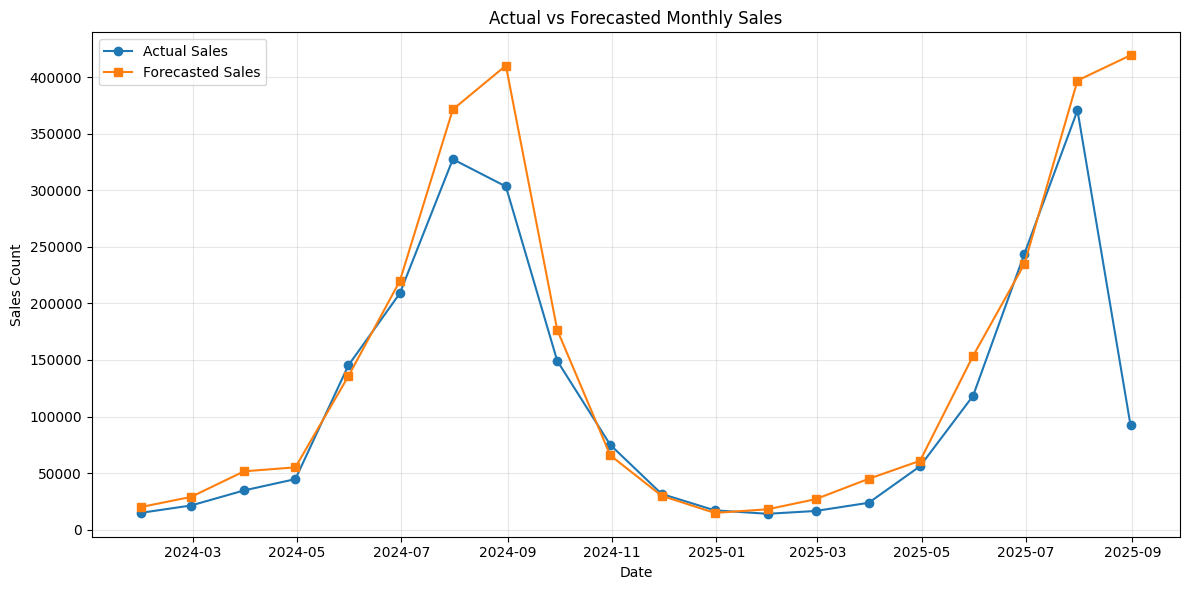

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(evaluation_df['ds'], evaluation_df['y'], label='Actual Sales', marker='o')
plt.plot(evaluation_df['ds'], evaluation_df['yhat'], label='Forecasted Sales', marker='s')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('Actual vs Forecasted Monthly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()